In [18]:
import os
import sys
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

# Scikit-learn imports for preprocessing, metrics, and PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.manifold import TSNE  # <-- For Better EDA
from mpl_toolkits.mplot3d import Axes3D

# Scikit-image imports for feature extraction
from skimage.feature import hog, graycomatrix, graycoprops, local_binary_pattern

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Magic command to display plots inline
%matplotlib inline
sns.set(style="whitegrid")

print("All libraries imported successfully.")

All libraries imported successfully.


In [19]:
# --- Configuration ---
# ❗ **ACTION REQUIRED**: Update this to the FULL, ABSOLUTE path to your code folder.
# Example: CLASSIFIER_DIR = r'C:\Users\jaink\OneDrive\Desktop\ML_Project\Classifier_codes'
CLASSIFIER_DIR = r'/home/lightshadow/pseudoD/Sem 5/HealthBuddy/Classifier_codes'
# ---------------------

if not os.path.isdir(CLASSIFIER_DIR):
    print(f"Error: Classifier directory '{CLASSIFIER_DIR}' not found.")
    print("Please update the path in this cell.")
else:
    # Add the folder to the system path to allow imports
    if CLASSIFIER_DIR not in sys.path:
        sys.path.append(os.path.abspath(CLASSIFIER_DIR))
    
    try:
        # Import all 9 of your classifier classes
        from KNN import KNN
        from LogisticRegression import LogisticRegression
        from DecisionTree import DecisionTreeClassifier # Assumes Node class is in this file
        from RandomForest import RandomForestClassifier # Assumes this imports DecisionTree
        from SVM import LinearSVM
        from GaussianNaiveBayes import GaussianNaiveBayes
        from MultiLayerPerceptron import SimpleMLP
        from LinearDiscriminantAnalysis import LDA
        from AdaBoost import AdaBoost # Assumes DecisionStump is in this file
        
        print("✅ Successfully imported all 9 from-scratch classifiers.")
    except ImportError as e:
        print(f"--- 🛑 IMPORT ERROR ---")
        print(f"Error importing classifiers: {e}")
        print("Please check file/class names in your 'Classifier_codes' folder.")
    except Exception as e:
        print(f"An unexpected error occurred during import: {e}")

✅ Successfully imported all 9 from-scratch classifiers.


In [20]:
# This helper class allows binary models (LogReg, SVM, MLP, AdaBoost)
# to work for multi-class problems.

class OvRWrapper:
    """Wraps a binary classifier to support multi-class OvR classification."""
    def __init__(self, binary_classifier_class, **kwargs):
        self.binary_classifier_class = binary_classifier_class
        self.kwargs = kwargs
        self.models = {}
        self.classes_ = None
        self.binary_le = None # For handling the binary-only case

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        if n_classes <= 2:
            # Standard binary problem
            self.binary_le = LabelEncoder() # Use 0/1
            y_binary = self.binary_le.fit_transform(y)
            model = self.binary_classifier_class(**self.kwargs)
            model.fit(X, y_binary)
            self.models[self.binary_le.classes_[1]] = model # Store model keyed by positive class
        else:
            # Multi-class OvR problem
            for cls in self.classes_:
                y_train_binary = np.where(y == cls, 1, 0)
                model = self.binary_classifier_class(**self.kwargs)
                model.fit(X, y_train_binary)
                self.models[cls] = model
    
    def predict(self, X):
        if len(self.models) == 1 and self.binary_le:
             # Binary case
             model_key = list(self.models.keys())[0]
             binary_preds = self.models[model_key].predict(X)
             return self.binary_le.inverse_transform(binary_preds)
        else:
            # Multi-class OvR case
            all_scores = []
            for cls in self.classes_:
                model = self.models[cls]
                
                # Try to get probabilities (best), then decision scores, then raw predicts (worst)
                if hasattr(model, 'predict_proba'):
                    probas = model.predict_proba(X)
                    all_scores.append(probas[:, 1] if probas.ndim == 2 and probas.shape[1] == 2 else probas)
                elif hasattr(model, 'decision_function'):
                    all_scores.append(model.decision_function(X))
                else:
                    all_scores.append(model.predict(X))
            
            scores_matrix = np.stack(all_scores, axis=1)
            best_class_indices = np.argmax(scores_matrix, axis=1)
            return self.classes_[best_class_indices]

print("OvRWrapper class defined.")

OvRWrapper class defined.


In [21]:
# --- Feature Extraction Functions (from your script) ---
print("Defining feature extraction functions: HOG, GLCM, LBP, Statistical...")

def extract_hog(img):
    hog_features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys',
                          visualize=True, transform_sqrt=True)
    return hog_features

def extract_glcm_features(img):
    glcm = graycomatrix(img, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    features = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'dissimilarity')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0]
    ]
    return features

def extract_lbp_features(img):
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, 10),
                             range=(0, 9))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_statistical_features(img):
    mean = np.mean(img)
    var = np.var(img)
    skew = np.mean((img - mean)**3) / (np.std(img)**3 + 1e-6)
    kurt = np.mean((img - mean)**4) / (np.std(img)**4 + 1e-6)
    # Corrected entropy calculation
    hist = np.histogram(img.ravel(), 256, [0,256])[0]
    hist_norm = hist.astype("float") / (hist.sum() + 1e-6)
    entropy = -np.sum(hist_norm * np.log2(hist_norm + 1e-6))
    return [mean, var, skew, kurt, entropy]

def extract_features_from_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Warning: Could not read image {img_path}. Skipping.")
        return None
    
    img = cv2.resize(img, (128, 128))

    hog_f = extract_hog(img)
    glcm_f = extract_glcm_features(img)
    lbp_f = extract_lbp_features(img)
    stat_f = extract_statistical_features(img)

    combined = np.hstack([hog_f, glcm_f, lbp_f, stat_f])
    return combined

print("Feature functions defined.")

Defining feature extraction functions: HOG, GLCM, LBP, Statistical...
Feature functions defined.


In [22]:
# --- Dataset Loader Function (from your script) ---
def load_dataset(folder_path):
    features, labels = [], []
    if not os.path.isdir(folder_path):
        print(f"Error: Directory not found at {folder_path}")
        return np.array([]), np.array([])
        
    for label in os.listdir(folder_path):
        subfolder = os.path.join(folder_path, label)
        if not os.path.isdir(subfolder):
            continue
        
        print(f"  Processing class: {label}")
        for file in os.listdir(subfolder):
            img_path = os.path.join(subfolder, file)
            try:
                feature_vector = extract_features_from_image(img_path)
                if feature_vector is not None:
                    features.append(feature_vector)
                    labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                
    return np.array(features), np.array(labels)

print("Dataset loader function defined.")

Dataset loader function defined.


In [23]:
# --- Load Training & Testing Data ---
# ❗ **ACTION REQUIRED**: Set your data folder paths relative to this notebook
train_path = "Training"
test_path = "Testing"

if not os.path.isdir(train_path) or not os.path.isdir(test_path):
    print(f"Error: '{train_path}' or '{test_path}' folders not found.")
    print("Please make sure these folders are in the same directory as the notebook.")
else:
    print(f"Loading and extracting features from '{train_path}'...")
    start_load = time.time()
    X_train_raw, y_train_labels = load_dataset(train_path)
    print(f"Training data loaded in {time.time() - start_load:.2f}s")
    
    print(f"\nLoading and extracting features from '{test_path}'...")
    start_load = time.time()
    X_test_raw, y_test_labels = load_dataset(test_path)
    print(f"Testing data loaded in {time.time() - start_load:.2f}s")

    print("\n--- Feature extraction complete ---")
    print(f"Raw training samples (X_train_raw): {X_train_raw.shape}")
    print(f"Raw testing samples (X_test_raw):  {X_test_raw.shape}")
    print(f"Training labels (y_train_labels): {y_train_labels.shape}")
    print(f"Testing labels (y_test_labels):  {y_test_labels.shape}")

Loading and extracting features from 'Training'...
  Processing class: notumor
  Processing class: pituitary
  Processing class: glioma
  Processing class: meningioma
Training data loaded in 284.07s

Loading and extracting features from 'Testing'...
  Processing class: notumor
  Processing class: pituitary
  Processing class: glioma
  Processing class: meningioma
Testing data loaded in 65.78s

--- Feature extraction complete ---
Raw training samples (X_train_raw): (5712, 8119)
Raw testing samples (X_test_raw):  (1311, 8119)
Training labels (y_train_labels): (5712,)
Testing labels (y_test_labels):  (1311,)


In [24]:
# --- Preprocessing: Scaling & PCA ---

print("Applying StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)
print("Data scaled.")

# ❗ **PARAMETER**: You can adjust n_components. 100 is a good start.
N_COMPONENTS = 100 

print(f"Applying PCA (reducing to {N_COMPONENTS} components)...")
pca = PCA(n_components=N_COMPONENTS)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("\n--- Preprocessing complete ---")
print(f"PCA-transformed training data (X_train_pca): {X_train_pca.shape}")
print(f"PCA-transformed testing data (X_test_pca):  {X_test_pca.shape}")

Applying StandardScaler...
Data scaled.
Applying PCA (reducing to 100 components)...

--- Preprocessing complete ---
PCA-transformed training data (X_train_pca): (5712, 100)
PCA-transformed testing data (X_test_pca):  (1311, 100)


In [25]:
# --- Preprocessing: Label Encoding ---
# Models need numeric labels (0, 1, 2, 3) not strings (e.g., 'glioma')

le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.transform(y_test_labels)

print("Labels encoded:")
for i, class_name in enumerate(le.classes_):
    print(f"  {class_name} -> {i}")
    
class_names = le.classes_
n_classes = len(class_names)
n_features_pca = X_train_pca.shape[1] # This will be 100

Labels encoded:
  glioma -> 0
  meningioma -> 1
  notumor -> 2
  pituitary -> 3


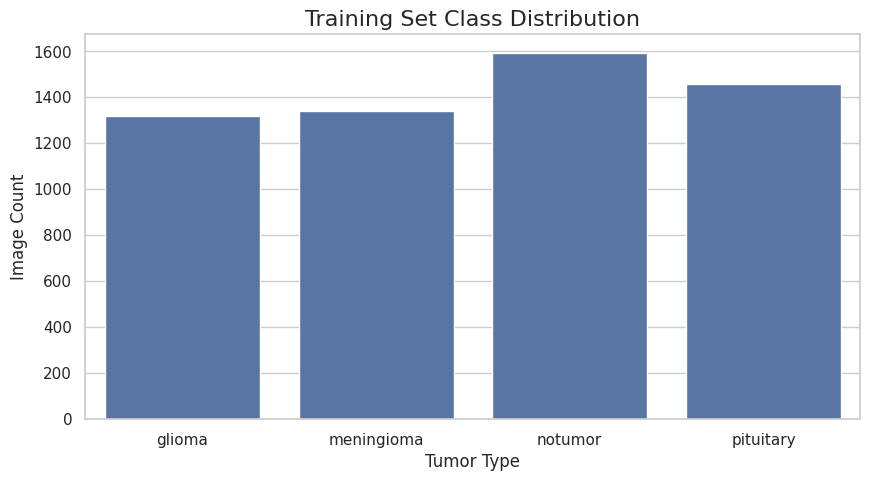

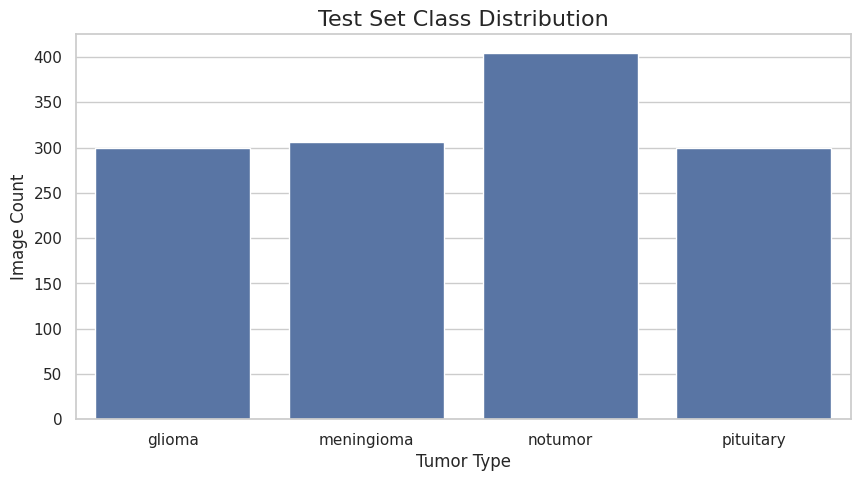

In [26]:

plt.figure(figsize=(10, 5))
sns.countplot(x=y_train_labels, order=np.unique(y_train_labels))
plt.title('Training Set Class Distribution', fontsize=16)
plt.xlabel('Tumor Type', fontsize=12)
plt.ylabel('Image Count', fontsize=12)
plt.show()

# --- 2. EDA: Test Set Class Distribution ---
plt.figure(figsize=(10, 5))
sns.countplot(x=y_test_labels, order=np.unique(y_test_labels))
plt.title('Test Set Class Distribution', fontsize=16)
plt.xlabel('Tumor Type', fontsize=12)
plt.ylabel('Image Count', fontsize=12)
plt.show()

Total variance explained by 100 components: 53.29%


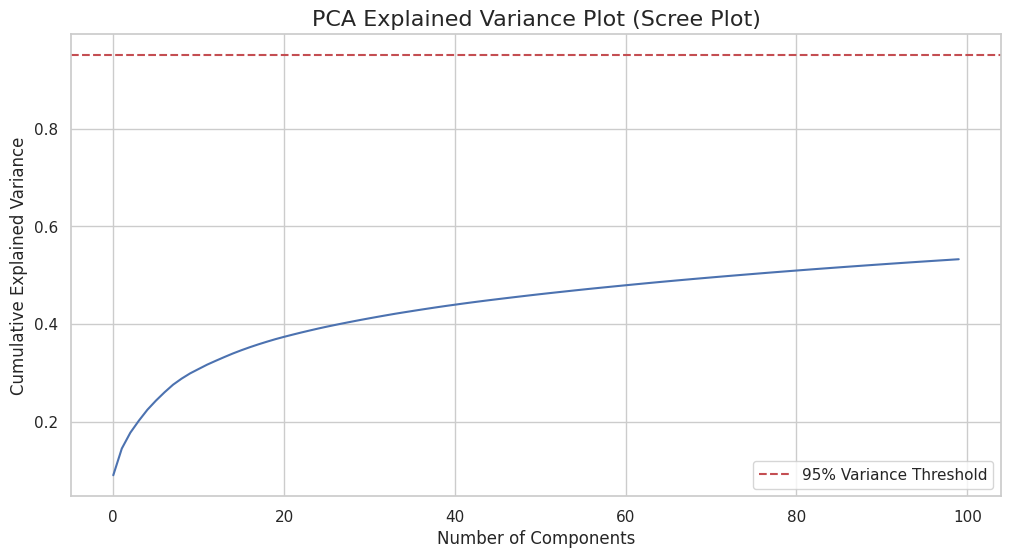

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance Plot (Scree Plot)', fontsize=16)
plt.grid(True)
# Plot a line for 95% variance
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend()
total_var = np.sum(pca.explained_variance_ratio_)*100
print(f"Total variance explained by {N_COMPONENTS} components: {total_var:.2f}%")
plt.show()

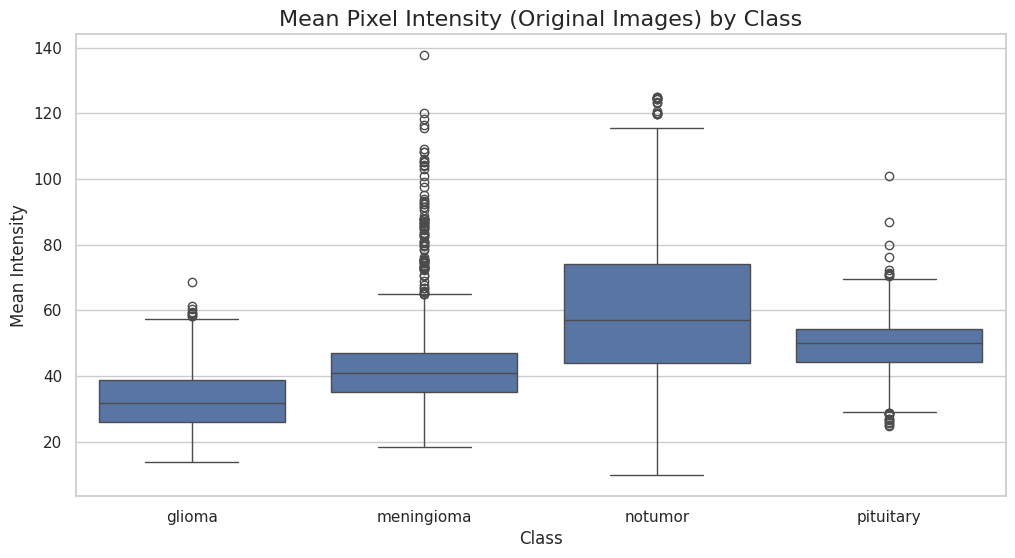

In [28]:
# 'stat_f' (mean, var, skew, kurt, entropy) are the last 5 features
mean_intensity_train = X_train_raw[:, -5] 

plt.figure(figsize=(12, 6))
sns.boxplot(x=y_train_labels, y=mean_intensity_train, order=np.unique(y_train_labels))
plt.title('Mean Pixel Intensity (Original Images) by Class', fontsize=16)
plt.xlabel('Class')
plt.ylabel('Mean Intensity')
plt.show()

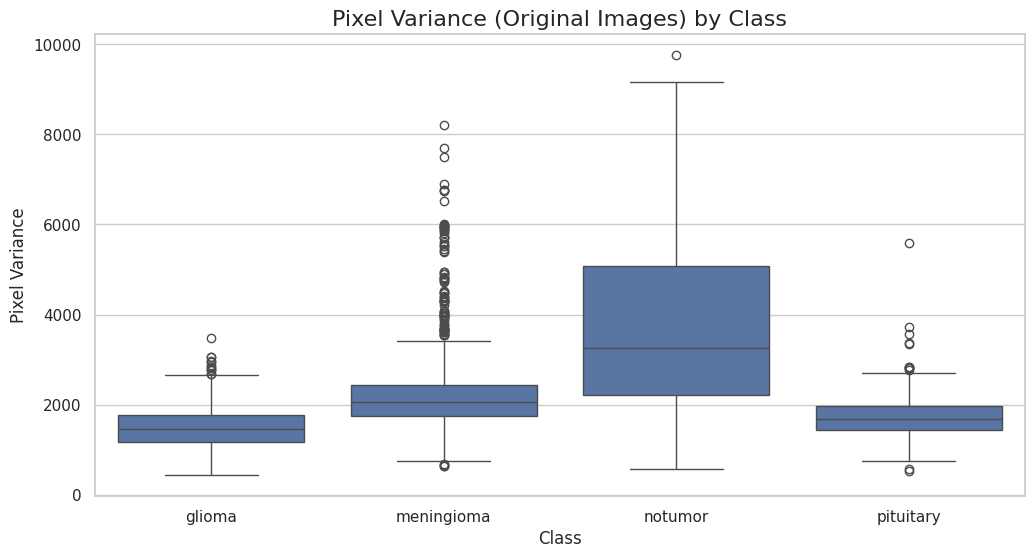

In [29]:
variance_train = X_train_raw[:, -4] 

plt.figure(figsize=(12, 6))
sns.boxplot(x=y_train_labels, y=variance_train, order=np.unique(y_train_labels))
plt.title('Pixel Variance (Original Images) by Class', fontsize=16)
plt.xlabel('Class')
plt.ylabel('Pixel Variance')
plt.show()

Displaying sample images from each class...


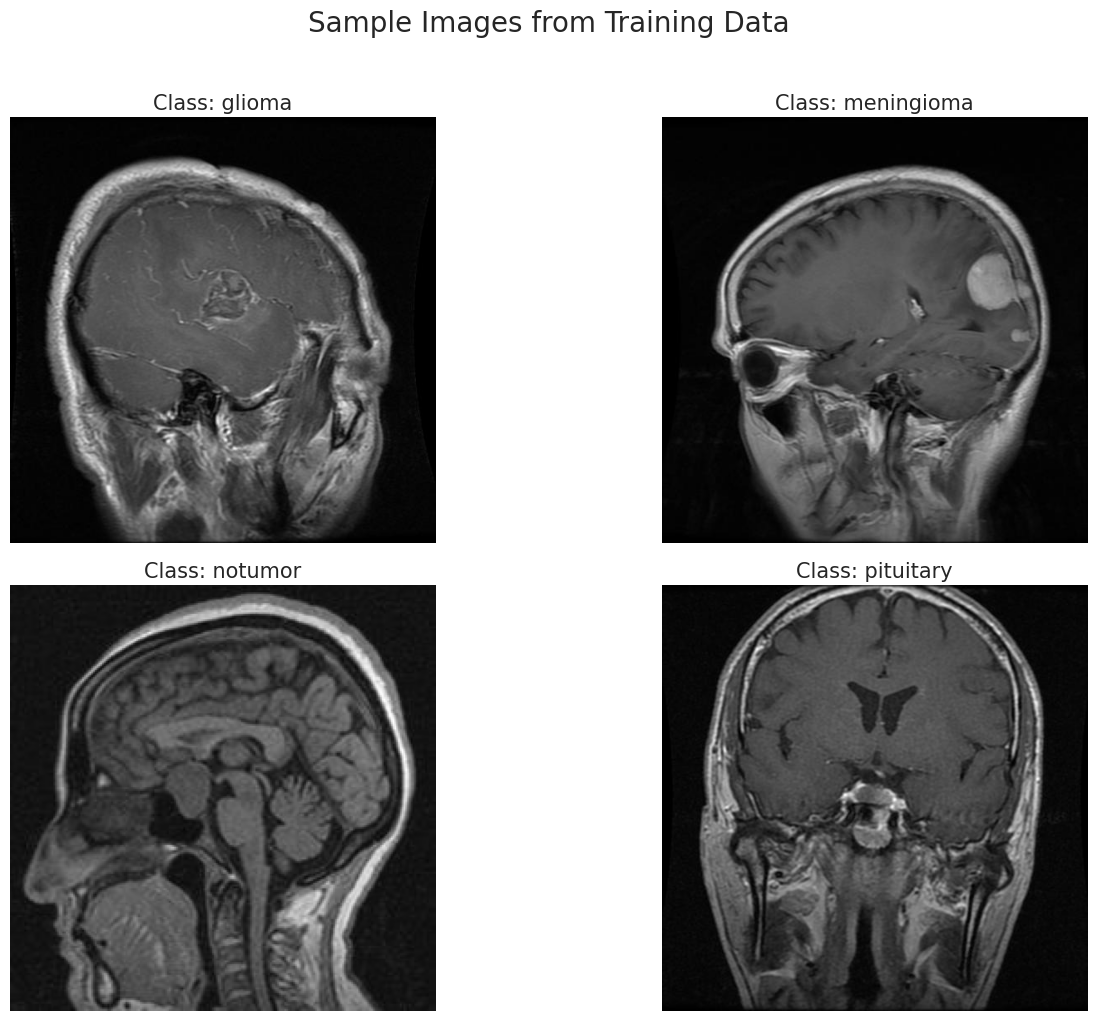

In [30]:
print("Displaying sample images from each class...")

plt.figure(figsize=(15, 10))
for i, label in enumerate(class_names):
    class_folder = os.path.join(train_path, label)
    if not os.path.isdir(class_folder): continue
    
    # Find the first image in the folder
    first_image_name = os.listdir(class_folder)[0]
    img_path = os.path.join(class_folder, first_image_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert for matplotlib
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {label}", fontsize=15)
    plt.axis('off')
plt.suptitle("Sample Images from Training Data", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

Running T-SNE on 1000 scaled raw feature samples... (This may take a minute)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.004s...


/home/lightshadow/pseudoD/Sem 5/HealthBuddy/venv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 1000 samples in 0.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 31.145050
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.743301
[t-SNE] KL divergence after 300 iterations: 0.845930
T-SNE complete. Plotting...


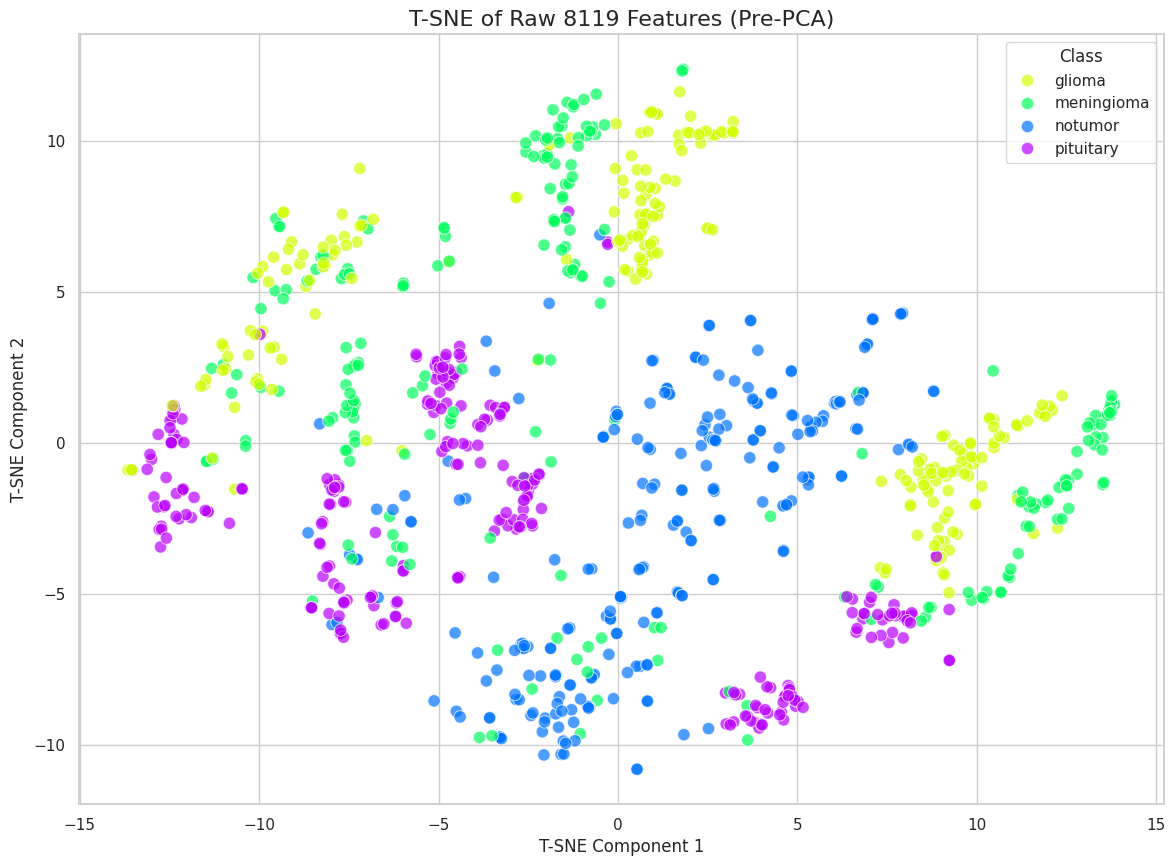

In [31]:
# This visualizes the separability of your 8119 features.
# It's slow, so we'll use a random subset of 1000 samples.

print("Running T-SNE on 1000 scaled raw feature samples... (This may take a minute)")
n_samples_tsne = 1000
if len(X_train_scaled) > n_samples_tsne:
    idx = np.random.choice(len(X_train_scaled), n_samples_tsne, replace=False)
    X_tsne_data = X_train_scaled[idx]
    y_tsne_labels = y_train_labels[idx]
else:
    X_tsne_data = X_train_scaled
    y_tsne_labels = y_train_labels

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X_tsne_data)

print("T-SNE complete. Plotting...")
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=y_tsne_labels,
    hue_order=class_names,
    palette=sns.color_palette("hsv", n_classes),
    s=80, alpha=0.7
)
plt.title('T-SNE of Raw 8119 Features (Pre-PCA)', fontsize=16)
plt.xlabel('T-SNE Component 1', fontsize=12)
plt.ylabel('T-SNE Component 2', fontsize=12)
plt.legend(title='Class')
plt.show()

In [32]:
# --- Model Training Pipeline (ALL MODELS, FASTER PARAMS) ---
print("Defining model pipeline... (All models, faster parameters)")

# These models are multi-class ready (or support it natively)
multi_class_models = {
    "KNN (From-Scratch)": KNN(k=5), # Already fast to train
    "GNB (From-Scratch)": GaussianNaiveBayes(), # Already fast to train
    "LDA (From-Scratch)": LDA(), # Already fast to train
    "DT (From-Scratch)": DecisionTreeClassifier(max_depth=10, min_samples_split=3), # Already fast
    "RF (From-Scratch)": RandomForestClassifier(
        n_trees=10,           
        max_depth=10, 
        min_samples_split=3
    ),
}

# These models are binary, so we wrap them with OvR
binary_models_to_wrap = {
    "LogReg (From-Scratch)": (LogisticRegression, {
        "learning_rate": 0.01, 
        "n_iters": 100,         # <-- FASTER (was 1000)
        "verbose": False
    }),
    "SVM (From-Scratch)": (LinearSVM, {
        "learning_rate": 0.001, 
        "lambda_param": 0.01, 
        "n_iters": 100,         # <-- FASTER (was 1000)
        "verbose": False
    }),
    "MLP (From-Scratch)": (SimpleMLP, {
        "n_input": n_features_pca, 
        "n_hidden": 16, 
        "n_output": 1, 
        "learning_rate": 0.01, 
        "n_iters": 100,         # <-- FASTER (was 1000)
        "verbose": False, 
        "activation": 'relu'
    }),
}

# --- Combine the dictionaries ---
all_models = multi_class_models.copy()
for name, (model_class, kwargs) in binary_models_to_wrap.items():
    all_models[name] = OvRWrapper(model_class, **kwargs)
    
print(f"Total models to train: {len(all_models)}")
print("Models to run:", list(all_models.keys()))

Defining model pipeline... (All models, faster parameters)
Total models to train: 8
Models to run: ['KNN (From-Scratch)', 'GNB (From-Scratch)', 'LDA (From-Scratch)', 'DT (From-Scratch)', 'RF (From-Scratch)', 'LogReg (From-Scratch)', 'SVM (From-Scratch)', 'MLP (From-Scratch)']


In [33]:
# --- Run All Models ---
results = {}
reports = {}

print("\n--- Running Model Benchmarks on PCA Data ---")

for name, model in all_models.items():
    try:
        print(f"\n--- Training {name} ---")
        start_time = time.time()
        
        # We use the scaled PCA data for all models
        model.fit(X_train_pca, y_train)
        
        print(f"  Predicting with {name}...")
        y_pred = model.predict(X_test_pca)
        
        duration = time.time() - start_time
        acc = accuracy_score(y_test, y_pred)
        # Generate report as a dictionary for later use
        report_dict = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
        
        results[name] = acc
        reports[name] = report_dict
        
        print(f"  ✅ {name} Accuracy: {acc:<8.4f} (Time: {duration:.2f}s)")
    
    except Exception as e:
        import traceback
        print(f"  ❌ ERROR training/predicting with {name}: {e}")
        traceback.print_exc() 
        results[name] = 0.0
        reports[name] = str(e)


--- Running Model Benchmarks on PCA Data ---

--- Training KNN (From-Scratch) ---
KNN fitted with 5712 samples.
  Predicting with KNN (From-Scratch)...
Predicting for 1311 samples using KNN (k=5)...
  ✅ KNN (From-Scratch) Accuracy: 0.9115   (Time: 55.66s)

--- Training GNB (From-Scratch) ---
Fitting Gaussian Naive Bayes...
Fitting complete.
  Predicting with GNB (From-Scratch)...
Predicting labels for 1311 samples using GNB...
  ✅ GNB (From-Scratch) Accuracy: 0.7986   (Time: 0.01s)

--- Training LDA (From-Scratch) ---
Fitting LDA...
LDA fitting complete.
  Predicting with LDA (From-Scratch)...
Predicting labels for 1311 samples using LDA...
  ✅ LDA (From-Scratch) Accuracy: 0.8253   (Time: 0.01s)

--- Training DT (From-Scratch) ---
Fitting Decision Tree: max_depth=10, min_split=3, features_per_split=100...
Tree fitting complete.
  Predicting with DT (From-Scratch)...
Predicting labels for 1311 samples using Decision Tree...
  ✅ DT (From-Scratch) Accuracy: 0.8429   (Time: 569.74s)

--- 

In [34]:
# --- Final Results Summary ---

print("\n\n" + "="*30)
print("🏁 FINAL ACCURACY SUMMARY 🏁")
print("="*30 + "\n")

# Convert results to a DataFrame for easy sorting
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print(results_df.to_string())

# --- Print the Winner ---
best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Accuracy']

print(f"\n\n--- 🏆 Best Model ---")
print(f"{best_model_name} (Accuracy: {best_accuracy:.4f})")

# --- Print Classification Report for the Best Model ---
print("\n--- Classification Report for Best Model ---")
best_report_dict = reports[best_model_name]
if isinstance(best_report_dict, dict):
    best_report_df = pd.DataFrame(best_report_dict).transpose()
    print(best_report_df)
else:
    print(best_report_dict) # Print error message if it failed



🏁 FINAL ACCURACY SUMMARY 🏁

                   Model  Accuracy
0     KNN (From-Scratch)  0.911518
1      RF (From-Scratch)  0.871854
2      DT (From-Scratch)  0.842868
3     LDA (From-Scratch)  0.825324
4  LogReg (From-Scratch)  0.815408
5     SVM (From-Scratch)  0.802441
6     GNB (From-Scratch)  0.798627
7     MLP (From-Scratch)  0.784134


--- 🏆 Best Model ---
KNN (From-Scratch) (Accuracy: 0.9115)

--- Classification Report for Best Model ---
              precision    recall  f1-score      support
glioma         0.930796  0.896667  0.913413   300.000000
meningioma     0.875940  0.761438  0.814685   306.000000
notumor        0.924883  0.972840  0.948255   405.000000
pituitary      0.906061  0.996667  0.949206   300.000000
accuracy       0.911518  0.911518  0.911518     0.911518
macro avg      0.909420  0.906903  0.906390  1311.000000
weighted avg   0.910505  0.911518  0.909323  1311.000000


Predicting for 1311 samples using KNN (k=5)...


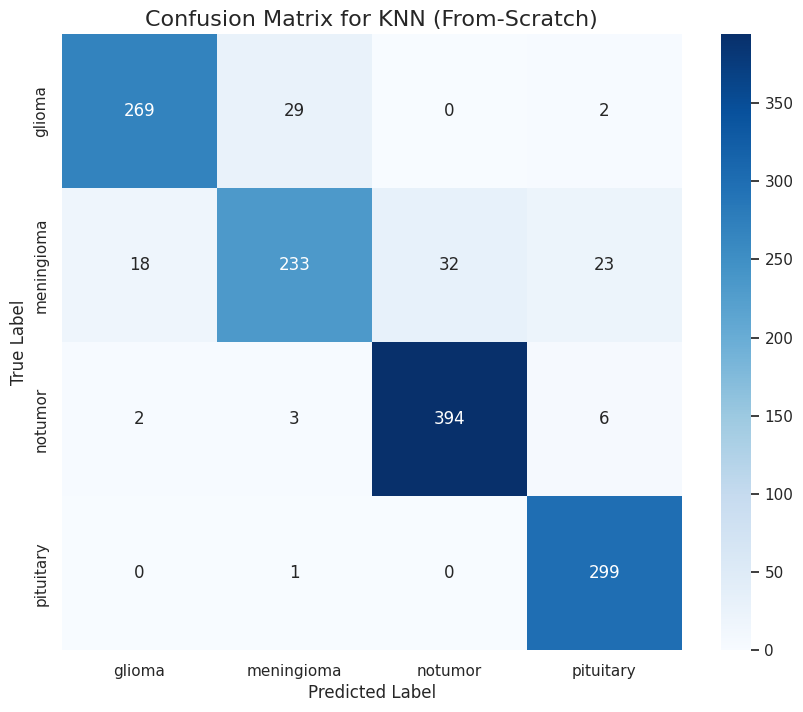

In [35]:
# --- Confusion Matrix for Best Model ---

# Re-run prediction for the best model to get y_pred
# (The model instance is already trained and stored in the dictionary)
best_model_instance = all_models[best_model_name]
y_pred_best = best_model_instance.predict(X_test_pca)

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix for {best_model_name}', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()